# [Experimental Design](https://app.diagrams.net/#G1WFQVzIGPYBEL60QfMwyWAW65AKrrtiM_#%7B%22pageId%22%3A%22Pm9vsCdeWVJZhLtSZE2a%22%7D)

In [1]:
import os
import glob
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import fiftyone as fo

from tator_tools.download_media import MediaDownloader
from tator_tools.fiftyone_clustering import FiftyOneDatasetViewer
from tator_tools.download_query import QueryDownloader
from tator_tools.yolo_dataset import YOLODataset
from tator_tools.yolo_crop_regions import YOLORegionCropper
from tator_tools.train_model import ModelTrainer
from tator_tools.inference_video import VideoInferencer

from yolo_tiler import YoloTiler, TileConfig

# Download Ground-Truth from Tator

- AUV Images (170 media, 201 images)
    - w/ Algorithm Masks
    - w/ Rock Masks
    - MissionName includes "AUV"
- Localizations (7119)
    - Version == Nicholas Y.

Creating multiple sets:
- Original dimensions
    - Tiled dimensions (1920 x 1080, no overlap)
- Reduced dimensions (1920 x 1080)

In [2]:
# Set parameters
api_token = os.getenv("TATOR_TOKEN")
project_id = 155

# Search string comes from Tator's Data Metadata Export utility
search_string = "eyJtZXRob2QiOiJBTkQiLCJvcGVyYXRpb25zIjpbeyJhdHRyaWJ1dGUiOiIkdmVyc2lvbiIsIm9wZXJhdGlvbiI6ImVxIiwiaW52ZXJzZSI6ZmFsc2UsInZhbHVlIjo4Njl9LHsibWV0aG9kIjoiT1IiLCJvcGVyYXRpb25zIjpbeyJhdHRyaWJ1dGUiOiIkdHlwZSIsIm9wZXJhdGlvbiI6ImVxIiwiaW52ZXJzZSI6ZmFsc2UsInZhbHVlIjo0NjB9LHsiYXR0cmlidXRlIjoiJHR5cGUiLCJvcGVyYXRpb24iOiJlcSIsImludmVyc2UiOmZhbHNlLCJ2YWx1ZSI6NTUzfV19XX0="

# Demo for downloading labeled data
frac = 1.0

dataset_name = "Ground-Truth"
output_dir = "../Data/RockFinder"

label_field = "Label"

In [3]:
# Create a downloader for the labeled data
downloader = QueryDownloader(api_token,
                             project_id=project_id,
                             search_string=search_string,
                             frac=frac,
                             output_dir=output_dir,
                             dataset_name=dataset_name,
                             label_field=label_field)

NOTE: Authentication successful for jordan.pierce
NOTE: Search string saved to e:\tator-tools\Data\RockFinder\Ground-Truth\search_string.txt


In [4]:
# Download the labeled data
downloader.download_data()

NOTE: Querying Tator for labeled data
NOTE: Found 8865 objects in query


Processing query: 100%|██████████| 8865/8865 [00:00<00:00, 11349.82it/s]


NOTE: Found 8865 query objects after sampling
NOTE: Data saved to e:\tator-tools\Data\RockFinder\Ground-Truth\data.csv
NOTE: Data saved to e:\tator-tools\Data\RockFinder\Ground-Truth\data.json
NOTE: Downloading images to e:\tator-tools\Data\RockFinder\Ground-Truth\images


NOTE: Images downloaded to e:\tator-tools\Data\RockFinder\Ground-Truth\images


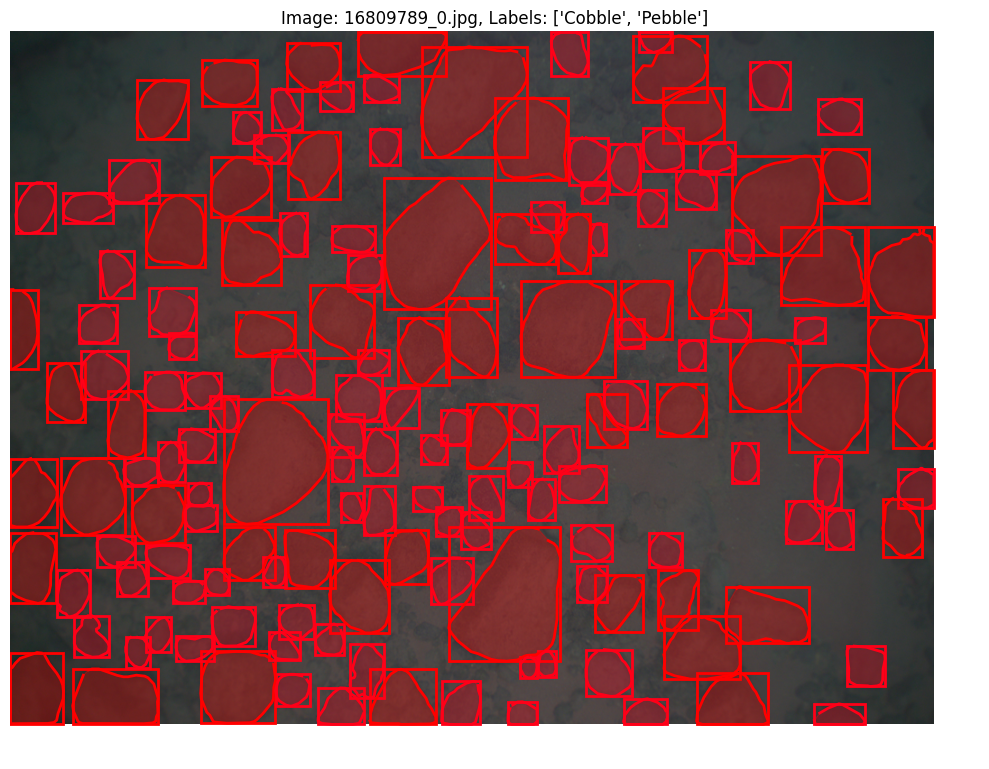

In [5]:
downloader.display_sample()

# Dataset Split

### Ground-Truth 

First, we create a YOLO Dataset (instance segmentation) with the following split:
- Train 70%
- Valid 10%
- Test 20%

### Resized

Next, we'll resize each image to be smaller, as the original images are too big to train with anyways. The labels
for the `Ground-Truth` set are in normalized coordinates, so those do not need to be changed if we alter the images.

### Tiled

Finally, we'll tile the `Ground-Truth` to the same dimensions as the `Resized` set; we can do this by using 
`yolo-tiling`, and simply pointing to the `Ground-Truth` set.


### Ground-Truth

In [6]:
data_dir = "../Data/RockFinder"

# Create a YOLO Dataset using the Ground-Truth data.
# Read in the dataframe from the downloaded data
df = pd.read_csv(f"{data_dir}/Ground-Truth/data.csv")

# Labels are not important for training, fill any NaNs with a placeholder
df = df.fillna({'label': 'Unlabeled'})

# Change the type of 'polygon' from a lists of lists of strings, to floats
# Alternatively, just read the data as a JSON, convert to pandas
df['polygon'] = df['polygon'].apply(eval)
df['polygon'] = df['polygon'].apply(lambda x: np.array(x, dtype=np.float32))

df.sample(3)

,media,frame,image_name,image_path,image_width,image_height,x,y,width,height,polygon,label
6391,14768674,1947,14768674_1947.jpg,e:\tator-tools\Data\RockFinder\Ground-Truth\im...,NaN,NaN,0.467708,0.789815,0.086458,0.103704,"[[0.46770832, 0.8564815], [0.47083333, 0.87037...",Cobble
3391,16809519,0,16809519_0.jpg,e:\tator-tools\Data\RockFinder\Ground-Truth\im...,NaN,NaN,0.769287,0.334000,0.066895,0.128667,"[[0.8137207, 0.335], [0.8063965, 0.334], [0.79...",Cobble
5000,14768410,5820,14768410_5820.jpg,e:\tator-tools\Data\RockFinder\Ground-Truth\im...,NaN,NaN,0.188042,0.454545,0.271231,0.246533,"[[0.3509532, 0.7010786], [0.3275563, 0.6810477...",Pebble Bed


In [7]:
# Set parameters
output_dir = f"{data_dir}/Ground-Truth"
dataset_name = "YOLO_Dataset_Ground-Truth"

train_ratio = 0.7
test_ratio = 0.2

task = 'segment' # 'detect' or 'segment'

In [8]:
# Create and process dataset
dataset = YOLODataset(
    data=df,
    output_dir=output_dir,
    dataset_name=dataset_name,
    train_ratio=train_ratio,
    test_ratio=test_ratio,
    task=task,
    format_class_names=True, 
)

In [9]:
# Process the dataset
dataset.process_dataset(move_images=False)  # Makes a copy of the images instead of moving them

Processing YOLO dataset with 8865 annotations...
Dataset split: 140 train, 21 valid, 40 test images


Writing segmentation labels:   0%|          | 0/201 [00:00<?, ?it/s]

Copying images:   0%|          | 0/201 [00:00<?, ?it/s]

Dataset created at e:\tator-tools\Data\RockFinder\Ground-Truth\YOLO_Dataset_Ground-Truth
Classes: ['Boulder', 'Cobble', 'FallenWood', 'FineSediment', 'Pebble', 'PebbleBed', 'Pebblebed', 'Pebbles', 'Sand', 'Unknown', 'Unlabeled', 'WoodyDebris']


Rendering Examples:   0%|          | 0/10 [00:00<?, ?it/s]

Rendered 10 examples to e:\tator-tools\Data\RockFinder\Ground-Truth\YOLO_Dataset_Ground-Truth\examples


In [10]:
dataset.dataset_dir

'e:\\tator-tools\\Data\\RockFinder\\Ground-Truth\\YOLO_Dataset_Ground-Truth'

### Ground-Truth Tiled Dataset (1920 x 1080, no overlap)

In [16]:
config = TileConfig(
    # Size of each tile (width, height). Can be:
    # - Single integer for square tiles: slice_wh=640
    # - Tuple for rectangular tiles: slice_wh=(640, 480)
    slice_wh=(1920, 1080),

    # Overlap between adjacent tiles. Can be:
    # - Single float (0-1) for uniform overlap percentage: overlap_wh=0.1
    # - Tuple of floats for different overlap in each dimension: overlap_wh=(0.1, 0.1)
    # - Single integer for pixel overlap: overlap_wh=64
    # - Tuple of integers for different pixel overlaps: overlap_wh=(64, 48)
    overlap_wh=(0.0, 0.0),

    # Input image file extension to process
    input_ext=".jpg",

    # Output image file extension to save (default: same as input_ext)
    output_ext=None,

    # Type of YOLO annotations to process:
    # - "object_detection": Standard YOLO format (class, x, y, width, height)
    # - "instance_segmentation": YOLO segmentation format (class, x1, y1, x2, y2, ...)
    annotation_type="instance_segmentation",

    # Include negative samples (tiles without any instances)
    include_negative_samples=True
)

src = f"{data_dir}/Ground-Truth/YOLO_Dataset_Ground-Truth"              
dst = f"{data_dir}/Ground-Truth/YOLO_Dataset_Ground-Truth-Tiled"     

tiler = YoloTiler(
    source=src,
    target=dst,
    config=config,
    num_viz_samples=15,                     # Number of samples to visualize
    show_processing_status=False,            # Show the progress of the tiling process
)

In [ ]:
tiler.run()

### Ground-Truth Resized Dataset (1920 x 1080)

In [19]:
src = f"{data_dir}/Ground-Truth/YOLO_Dataset_Ground-Truth"
dst = f"{data_dir}/Ground-Truth/YOLO_Dataset_Ground-Truth-Resized"

In [20]:
# First, make a copy of the source directory
if os.path.exists(dst):
    shutil.rmtree(dst)
shutil.copytree(src, dst)

# Find all image files recursively
img_files = glob.glob(f"{dst}/**/*.jpg", recursive=True)

# Resize dimensions
width, height = 1920, 1080

# Process each image
for img_path in img_files:
    # Open image
    img = Image.open(img_path)
    
    # Resize maintaining aspect ratio
    img = img.resize((width, height))
    
    # Save back to same path
    img.save(img_path, quality=95)

In [22]:
# --> Manually adjust the data.yaml file <--

# Train Models

### Benchmark (YOLOv8m on Ground-Truth Resized)

In [7]:
root = f"{data_dir}/Ground-Truth/YOLO_Dataset_Ground-Truth-Resized"

# Initialize the trainer with the required parameters
trainer = ModelTrainer(
    training_data=f"{root}/data.yaml",
    weights="yolov8m-seg.pt",
    output_dir=f"{root}",
    name="results",
    task="segment",
    epochs=50,
    patience=5,
    half=True,
    imgsz=640,
    single_cls=True,
    plots=True,
    batch=0.5,
)

# Train the model
trainer.train_model()

# Evaluate on the model (if test data is available)
trainer.evaluate_model()

100%|██████████| 52.4M/52.4M [00:00<00:00, 224MB/s]


New https://pypi.org/project/ultralytics/8.3.88 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.0  Python-3.10.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 16384MiB)
engine\trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=../Data/RockFinder/Ground-Truth/YOLO_Dataset_Ground-Truth-Resized/data.yaml, epochs=50, time=None, patience=5, batch=0.5, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=8, project=../Data/RockFinder/Ground-Truth/YOLO_Dataset_Ground-Truth-Resized, name=results, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=True, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fals